# SECOP 2 - XGBosst classifier


In [1]:
#!pip install plotly --upgrade

In [1]:
import pandas as pd
import numpy as np
import datetime
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from warnings import filterwarnings
pd.options.display.max_columns = 500

In [2]:
#!pip install plotly_express

In [3]:
import seaborn as sns
import plotly_express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
import psycopg2
engine = psycopg2.connect(
    database="final_db",
    user="juan",
    password="1234",
    host="nps-demo-instance.c2fezqs1nmx5.us-east-2.rds.amazonaws.com",
    port='5432'
)

ModuleNotFoundError: No module named 'psycopg2'

In [ ]:
cursor=engine.cursor()

In [ ]:
import pandas as pd

sql = """
SELECT *
FROM fix_secopi
limit 1000
"""
df=pd.read_sql(sql, con=engine)

In [ ]:
df.info()

## Objetivo

El objetivo del notebook es desarrollar modelos con la información actualmente disponible en la bases de datos fix_secopi. 
Esta base de datos contiene las siguientes modificaciones respecto a la base de datos del secop:

    1- Se incluyo la columna "SANCIÓN", la cual incluye un identificación para los contratos que han sido reportados como contratos con eventos de corrupción.
    
    2- Se incluyo la columna "Terminado" indica que un contrato ha sido entregado o finalizado de forma adecuada. Los contratos que presentan sanción no puede ser calificado como terminado
    
    
- El trabajo a desarrollar considera la selección de columnas de interés 
- Desarrollo de cluster con los datos con el objetivo de buscar alguna estructura en la data
- desarrollo de modelo de logistic regression a fin de plantear un posible modelo de predicción o score de corrupción [y = sanción y X= variables de interés]
- Desarrollo de RF a fn de encontrar un modelo de clasificación sobre la variable sanción

### EDA básico

In [ ]:
df_sample=df.copy()

In [ ]:
df_sample.describe().T

### EDA Histogramas por columnas de interés como contratos de mayor cuantía o datos de mayor cantidad de contratos terminados

In [ ]:
df.columns.unique()

Generación de columnas logaritmicas de cuantia de contrato y sanción

In [ ]:
df["Log_cuantia_contrato"] =[np.log(x) if x !=0 else 0 for x in df["cuantia_contrato"]] 
df["Log_valor_contrato_con_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_contrato_con_adiciones"]] 
df["Log_valor_total_de_adiciones"] =[np.log(x) if x !=0 else 0 for x in df["valor_total_de_adiciones"]] 
df["terminado"]=[int(x) for x in df["terminado"]]
df["sancion"]=[int(x) for x in df["sancion"]]

In [ ]:
colInteres=['identificacion_del_contratista', 'nombre_de_la_entidad','nit_de_la_entidad', 'nivel_entidad', 'orden_entidad',
'municipio_obtencion', 'municipio_entrega','nom_raz_social_contratista', 'moneda','cuantia_contrato',
'valor_contrato_con_adiciones','valor_total_de_adiciones',"Log_cuantia_contrato","Log_valor_contrato_con_adiciones",
"Log_valor_total_de_adiciones",'sancion', 'anno_firma_del_contrato','estado_del_proceso', 'fecha_de_firma_del_contrato',
'fecha_ini_ejec_contrato', 'fecha_fin_ejec_contrato','municipios_ejecucion', 'departamento_ejecucion', 'latitud',
'longitud','terminado']

Entidades con mayor cantidad de contratos, mayor cuantia del contrato, mayor cantidad de adiciones, mayor cantidad de sanciones, mayor cantidad de contratos terminados

In [ ]:
df.head(1)

In [ ]:
df["fecha_fin_ejec_contrato"]=pd.to_datetime(df["fecha_fin_ejec_contrato"])
df["anno_firma_del_contrato"]=pd.to_datetime(df["anno_firma_del_contrato"])

df["Anno_fin_ejec_contrato"]=[x.year for x in df["fecha_fin_ejec_contrato"]]
df["Numeroanno_firma_del_contrato"]=[x.year for x in df["anno_firma_del_contrato"]]

In [ ]:
ColCluster1= ["nivel_entidad",'orden_entidad',"municipio_obtencion","municipio_entrega","moneda",'departamento_ejecucion','Log_cuantia_contrato','Log_valor_total_de_adiciones','sancion',
 'Numeroanno_firma_del_contrato',"municipios_ejecucion","Anno_fin_ejec_contrato",'latitud', 'longitud','terminado']

In [ ]:
df[ColCluster1].head()

In [ ]:
import matplotlib.pyplot as plt

for i in df[ColCluster1].select_dtypes(exclude=['object']).columns.unique():
    sns.factorplot (x="sancion", y=i, kind="box", data=df[ColCluster1]);
    plt.title('Histogram {}'.format(i))
    plt.figure()

#### Kmeans





In [ ]:
def deal_with_nans(x, thresh=0.7):
    """
    Deal with nan data
    First drop columns for which there isn't enoug data.
    Then fill missing values using median for continuous features and mode for categorical
    Finally drop columns with no variability
    :param x: (pandas.DataFrame) features dataframe
    :param thresh: (float) features with missing values below the thresh are discarted
    :return: (pandas.DataFrame) cleaned dataframe
    """

    # Drop rows with no data
    dff = x.dropna(how='all')

    # Drops columns with not enough data
    dff.dropna(thresh=thresh * len(dff), axis=1, inplace=True)

    # Identify continuous features
    float_vars = [y for y in dff.columns if 'float' in str(dff[y].dtype)]

    # Fill missing values
    for feat in dff.columns:
        if feat in float_vars:
            # Fill continuous features with median
            dff[feat] = dff[feat].fillna(dff[feat].median())
        else:
            # Fill categorical features with mode
            dff[feat] = dff[feat].fillna(dff[feat].mode()[0])

    # Drops columns with no variability
    dff = dff[[y for y in dff.columns if len(dff[y].unique()) > 1]]

    # Returns dataframe with no NaNs
    return dff


def clean_outliers(x, alpha=0.05):
    """
    Put all outliers on the confidence interval limit.
    :param x: (pandas.DataFrame) matrix of features
    :param alpha: (float) significance, 5% by default
    :return: (pandas.DataFrame) matrix with no outliers
    """

    # Cleaning Initialization
    x_c = x.copy()

    # Identification of categorical variables
    cont_vars = [x for x in x_c.columns if 'float' in str(x_c[x].dtype)]

    # If no continuous variables
    if len(cont_vars) == 0:
        return x_c

    # Cleaning
    for var in cont_vars:
        ll = x_c[var].quantile(alpha)
        ul = x_c[var].quantile(1-alpha)
        x_c[var] = [ll if x < ll else (ul if x > ul else x) for x in x_c[var]]

    # Return
    return x_c


def standarize(x):
    """
    Normalize data
    :param x: (pandas.DataFrame) matrix to normalize
    :return: (pandas.DataFrame) normalized matrix
    """

    # Outliers Treatment
    x_oc = clean_outliers(x)

    scale = StandardScaler()
    return pd.DataFrame(scale.fit_transform(x_oc), columns=x.columns, index=x_oc.index)


def get_principal_componets(x, n_pca=None):
    """
    Obtain the principal components from a set of continuous features.
    If the number of components is not especified, the model find the minimum number
    required to explain 90% of variance.
    :param x: (pandas.DataFrame) matrix from which the components are extracted
    :param n_pca: number of components
    :return: (pandas.DataFrame) matrix of components
    """

    # Standarization
    x_std = standarize(x)

    # Identify minimum number of components to explain 90% of the variability
    if n_pca is None:
        pca = PCA(random_state=1234)
        pca.fit(x_std)
        loadings = [round(y, 2) for y in pca.explained_variance_ratio_]
        cumsumload = list(np.cumsum(loadings))
        ncomps = [(y + 1, cumsumload[y]) for y in range(len(cumsumload))]
        n_pca = [y for y in ncomps if y[1] >= 0.8][0][0]

    # Calculate and return pcs
    pca = PCA(n_components=n_pca, random_state=1234)
    dp = pd.DataFrame(
        pca.fit_transform(x_std),
        columns=['PCA '+str(i+1) for i in range(n_pca)],
        index=x.index
    )
    return dp


Selección de columnas de interés y prerpocesamiento para standarizar las variables númericas y hacer One-hot-encoding a las variables categoricas

In [ ]:
dfCluster=df[ColCluster1].replace([np.inf, -np.inf], np.nan)

In [ ]:
#Separación del tipo de datos
df_Numeric = dfCluster.select_dtypes(include=['float64','int64'])
df_Cat = dfCluster.select_dtypes(include=['object'])

In [ ]:

df_Numeric=df_Numeric.replace([np.inf, -np.inf], np.nan)
df_Numeric=deal_with_nans(df_Numeric) 

In [ ]:
# Estandarización de datos
scaler = StandardScaler()
# fit df
scaler.fit(df_Numeric)
StandardScaler(copy=True, with_mean=True, with_std=True)

df_StandScale = scaler.transform(df_Numeric)
# Df transform
df_StandScale= pd.DataFrame(df_StandScale, columns=df_Numeric.columns)

In [ ]:
df_Cat_OHE= pd.get_dummies(df_Cat)
df_Cat_OHE.shape

In [33]:
# PCA con el objetivo de reducir dimensionalmente la cantidad de columnas 

In [ ]:
Pca_Explication(df_Cat_OHE).T

In [ ]:
df_Cat_OHEPCA=get_principal_componets(df_Cat_OHE,16)

Obtención de pca de df numerico y df categorico

In [34]:
df_SOHE = pd.merge(df_Numeric, df_Cat_OHE, left_index=True, right_index=True, suffixes=('_Num', '_Cat'))

In [35]:
df_SOHE.head()

,Log_cuantia_contrato,Log_valor_total_de_adiciones,sancion,Numeroanno_firma_del_contrato,Anno_fin_ejec_contrato,latitud,longitud,terminado,nivel_entidad_NACIONAL,nivel_entidad_No Definida,nivel_entidad_TERRITORIAL,orden_entidad_DISTRITO CAPITAL,orden_entidad_NACIONAL CENTRALIZADO,orden_entidad_NACIONAL DESCENTRALIZADO,orden_entidad_No Definido,orden_entidad_TERRITORIAL DEPARTAMENTAL CENTRALIZADO,orden_entidad_TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 3,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5,orden_entidad_TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,municipio_obtencion_Abejorral,municipio_obtencion_Abrego,municipio_obtencion_Abriaquí,municipio_obtencion_Acacías,municipio_obtencion_Acandí,municipio_obtencion_Acevedo,municipio_obtencion_Achí,municipio_obtencion_Agrado,municipio_obtencion_Agua de Dios,municipio_obtencion_Aguachica,municipio_obtencion_Aguada,municipio_obtencion_Aguadas,municipio_obtencion_Aguazul,municipio_obtencion_Agustín Codazzi,municipio_obtencion_Aipe,municipio_obtencion_Albania,municipio_obtencion_Albán,municipio_obtencion_Alcalá,municipio_obtencion_Aldana,municipio_obtencion_Alejandría,municipio_obtencion_Algarrobo,municipio_obtencion_Algeciras,municipio_obtencion_Almaguer,municipio_obtencion_Almeida,municipio_obtencion_Alpujarra,municipio_obtencion_Altamira,municipio_obtencion_Alto Baudo,municipio_obtencion_Altos del Rosario,municipio_obtencion_Alvarado,municipio_obtencion_Amagá,municipio_obtencion_Amalfi,municipio_obtencion_Ambalema,municipio_obtencion_Anapoima,municipio_obtencion_Ancuyá,municipio_obtencion_Andalucía,municipio_obtencion_Andes,municipio_obtencion_Angelópolis,municipio_obtencion_Angostura,municipio_obtencion_Anolaima,municipio_obtencion_Anorí,municipio_obtencion_Anserma,municipio_obtencion_Ansermanuevo,municipio_obtencion_Anza,municipio_obtencion_Anzoátegui,municipio_obtencion_Apartadó,municipio_obtencion_Apulo,municipio_obtencion_Apía,municipio_obtencion_Aquitania,municipio_obtencion_Aracataca,municipio_obtencion_Aranzazu,municipio_obtencion_Aratoca,municipio_obtencion_Arauca,municipio_obtencion_Arauquita,municipio_obtencion_Arbeláez,municipio_obtencion_Arboleda,municipio_obtencion_Arboledas,municipio_obtencion_Arboletes,municipio_obtencion_Arcabuco,municipio_obtencion_Arenal,municipio_obtencion_Argelia,municipio_obtencion_Ariguaní/El Dificil,municipio_obtencion_Arjona,municipio_obtencion_Armenia,municipio_obtencion_Armero,municipio_obtencion_Arroyohondo,municipio_obtencion_Astrea,municipio_obtencion_Ataco,municipio_obtencion_Atrato,municipio_obtencion_Ayapel,municipio_obtencion_Bagadó,municipio_obtencion_Bahía Solano,municipio_obtencion_Bajo Baudó/Pizarro,municipio_obtencion_Balboa,municipio_obtencion_Baranoa,municipio_obtencion_Baraya,municipio_obtencion_Barbacoas,municipio_obtencion_Barbosa,municipio_obtencion_Barichara,municipio_obtencion_Barranca de Upía,municipio_obtencion_Barrancabermeja,municipio_obtencion_Barrancas,municipio_obtencion_Barranco Minas,municipio_obtencion_Barranco de Loba,municipio_obtencion_Barranquilla,municipio_obtencion_Becerril,municipio_obtencion_Belalcázar,municipio_obtencion_Bello,municipio_obtencion_Belmira,municipio_obtencion_Beltrán,municipio_obtencion_Belén,municipio_obtencion_Belén de Los Andaquies,municipio_obtencion_Belén de Umbría,municipio_obtencion_Berbeo,municipio_obtencion_Berruecos,municipio_obtencion_Betania,municipio_obtencion_Betulia,municipio_obtencion_Betéitiva,municipio_obtencion_Bituima,municipio_obtencion_Boavita,municipio_obtencion_Bocas De Satinga,municipio_obtencion_Bochalema,municipio_obtencion_Bogotá D.C.,municipio_obtencion_Bojacá,municipio_obtencion_Bojaya,municipio_obtencion_Bolívar,municipio_obtencion_Bosconia,municipio_obtencion_Boyacá,municipio_obtencion_Briceño,municipio_obtencion_Bucaramanga,municipio_obten

In [36]:
# Descripción distribución de datos en función de la categoría sancionado

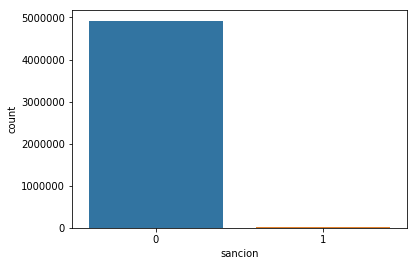

In [37]:
ax = sns.countplot(x="sancion", data=df_SOHE)

In [38]:
df_SOHE.groupby("sancion").agg("count")["terminado"]

MemoryError: 

In [ ]:
def plot_distribution(data_select): 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(dfCluster, hue = 'sancion',aspect = 2.5, palette ={0 : 'lime', 1 :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(dfCluster[data_select].min(), dfCluster[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

for i in df_Numeric.columns.unique():
   plot_distribution(i)   

In [ ]:
def plot_distribution(data_select): 
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(dfCluster, hue = 'sancion',aspect = 2.5, palette ={0 : 'lime', 1 :'black'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(dfCluster[data_select].min(), dfCluster[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

for i in df_Numeric.columns.unique():
   plot_distribution(i)   

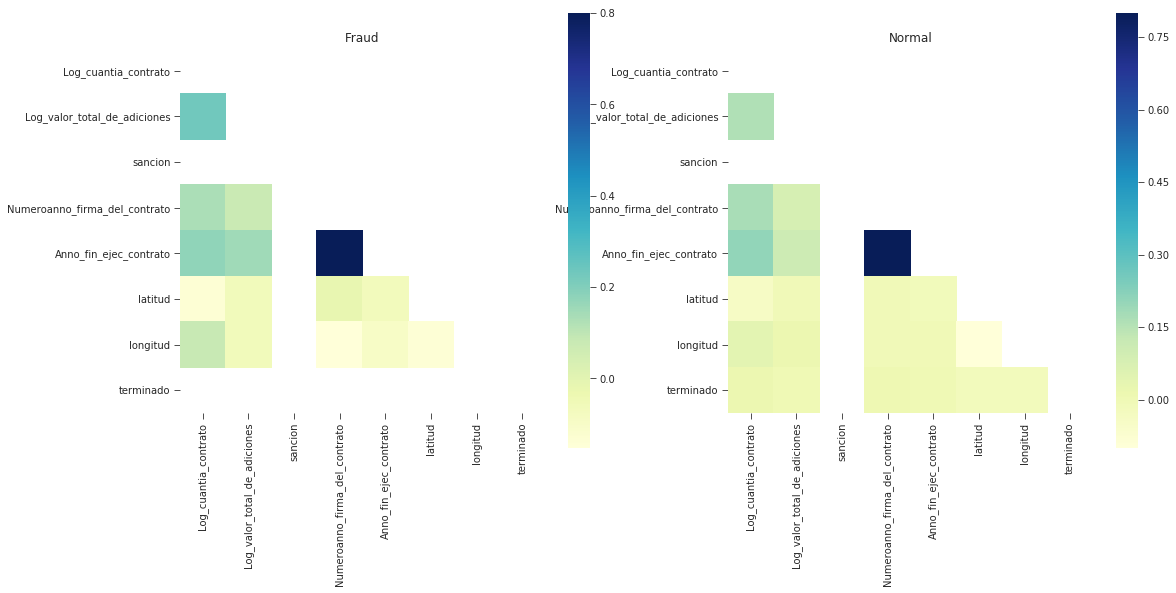

In [36]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = dfCluster.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((dfCluster.loc[dfCluster['sancion'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((dfCluster.loc[dfCluster['sancion'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

In [37]:
#### Kmeans sobre unión de df categoricos
X=df_SOHE.copy()
X=X.drop(columns=["sancion","terminado"])

In [38]:
y=df_SOHE["sancion"]

In [39]:
## Generación de modelo #1 - Modelo sin estratificación del modelo 

from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.tools import FigureFactory as FF
import warnings
warnings.filterwarnings('ignore')

In [40]:
def model_performance(model,y_test, y_pred,y_score): 
    #Conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    data=[[Accuracy , Precision, Recall, F1_score]]
    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    '''#Feature importance
    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data   = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))'''
    
    #Cumulative gain
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    #Subplots
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        #'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    #fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [41]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
!pip install xgboost
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from warnings import filterwarnings

#train test split
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

import numpy as np
import scipy.stats as st

def get_feature_importances(X, y, regularize=True):
    """
    Use Random Forest Classifier/Regressor to estimate X features importance into y target. 
    Use of RandomSearchCV to make an hypertunning of the Random Forest Classifier/Regressor parameters such like number of trees or max depth.
    Once the best parameters are tune. A model is fitted with a train set and validate with a test set. The score of both models are displayed.
    Assumes categorical variables are already encoded.
    :param X: (pandas.DataFrame) matrix of features, assumes categorical variables are already enconded
    :param y: (pandas.Series) target, can be continuous or categorical
    :return: (pandas.DataFrame) explained variability for each of the features
    """

    # Grid parameters for random forest hypertunning
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
    # get setup
    #pprint(random_grid)   
    
    # Create the random grid for XGB model
    params = {  
        "n_estimators": st.randint(10, 1000),
        "max_depth": st.randint(3, 10),
        "learning_rate": st.uniform(0.03, 1.0),
        'reg_alpha':  st.expon(0, 50),
        "min_child_weight": st.expon(0, 50),
        #"colsample_bytree": [0.5, 0.7, 0.9, 1.0],
        #"subsample": [0.5, 0.7, 0.9, 1.0],
        #"gamma": st.uniform(0, 10),
    }
    
    # Identify the kind of model to perform, "reg" for regression and "clas" for classification
    kind = 'reg' if 'float' in str(y.dtype) else 'clas'

    # Model initialization and regularization
    if kind == 'clas':
        model = RandomForestClassifier(criterion='entropy', random_state=1234)
        
        modelXG = XGBClassifier(tree_method='gpu_hist', gpu_id=0,  random_state=1234, booster='gbtree')
    else:
        model = RandomForestRegressor(random_state=1234)
        
        modelXG = XGBRegressor(nthreads=-1, random_state=1234, booster='gbtree')
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1234)
    
    # randomSearchCV RF
    model_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid,
                              n_iter = 100, scoring='accuracy', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
    #Fit to get best model RandomForest
    model_random.fit(X_train, y_train)

    #XGBoost randomsearchCV
    gs = RandomizedSearchCV(modelXG, params, n_jobs=-1, random_state=1234, cv=3, n_iter=100)
    # fit XGB
    gs.fit(X_train, y_train)
    
    best_fit = gs.best_estimator_
    
    #print(best_fit)
    best_fit.fit(X_train, y_train)
    

    ### Print the best parameters
    #print("Best model parameters")
    #pprint(model_random.best_estimator_)
    # Selecction of best model 
    BestModel= model_random.best_estimator_
    # Fit of the best model
    BestModel.fit(X_train, y_train)

    XG_train_score = best_fit.score(X_train, y_train)
    XG_test_score = best_fit.score(X_test, y_test)
    M_train_Score=BestModel.score(X_train, y_train)
    M_test_Score=BestModel.score(X_test, y_test)
    # Print Score modelo
    print("El Score de training del modelo fue: {}".format(M_train_Score))
    print("El Score de test del modelo fue: {}".format(M_test_Score))
    print("El Score de training del modelo XG fue: {}".format(XG_train_score))
    print("El Score de test del modelo  XG fue: {}".format(XG_test_score))

    print("y predict rf")
    y_predRF = BestModel.predict(X_test)
    print("y predict xg")
    y_predXG = best_fit.predict(X_test)
    
    if ((M_train_Score)  >=(XG_train_score)) & ((M_train_Score)  >= 0.4):
        # Explained Variability Calculation
        importances = pd.DataFrame(BestModel.feature_importances_.tolist(), columns=['explanation'])
        features = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
        df = pd.concat([features, importances], axis=1)
        #df.explanation = df.explanation * BestModel.score(X_train, y_train) * 100
        df.sort_values('explanation', ascending=False, inplace=True)
        df.set_index('feature', inplace=True)
    elif (M_test_Score/abs(M_train_Score) ) >= (XG_test_score/abs(XG_train_score)):
        # Explained Variability Calculation
        importances = pd.DataFrame(BestModel.feature_importances_.tolist(), columns=['explanation'])
        features = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
        df = pd.concat([features, importances], axis=1)
        #df.explanation = df.explanation * BestModel.score(X_train, y_train) * 100
        df.sort_values('explanation', ascending=False, inplace=True)
        df.set_index('feature', inplace=True)    
    else:
        # Explained Variability Calculation
        importances = pd.DataFrame(best_fit.feature_importances_.tolist(), columns=['explanation'])
        features = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
        df = pd.concat([features, importances], axis=1)
        #df.explanation = df.explanation * best_fit.score(X_train, y_train) * 100
        df.sort_values('explanation', ascending=False, inplace=True)
        df.set_index('feature', inplace=True)    
    # Return
    return df, best_fit, BestModel,y_train,y_test,y_predRF,y_predXG

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
## def lightgm
!pip install lightgbm
import lightgbm as lgbm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
def get_lightgbm(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1234)
  fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test,y_test)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

  param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
                'num_leaves': sp_randint(6, 50), 
                'min_child_samples': sp_randint(100, 500), 
                'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                'subsample': sp_uniform(loc=0.2, scale=0.8), 
                'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
                'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
                'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

  #number of combinations
  n_iter = 2 #(replace 2 by 200, 90 minutes)
  

  #intialize lgbm and lunch the search
  lgbm_clf = lgbm.LGBMClassifier(random_state=1234, silent=True, metric='None', n_jobs=-1)
  grid_search = RandomizedSearchCV(
      estimator=lgbm_clf, param_distributions=param_test, 
      n_iter=n_iter,
      scoring='accuracy',
      cv=5,
      refit=True,
      random_state=1234,
      verbose=True)

  grid_search.fit(X_train, y_train, **fit_params)
  print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

  opt_parameters =  grid_search.best_params_

  clf_sw = lgbm.LGBMClassifier(**lgbm_clf.get_params())
  #Optimal parameter
  clf_sw.set_params(**opt_parameters)
  clf_sw.fit(X_train, y_train)
  clf_sw.fit(X_train, y_train)
  y_pred = clf_sw.predict(X_test)
  y_score = clf_sw.predict_proba(X_test)[:,1]
  return y_pred,y_score,clf_sw

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
resultadoClasificadorRFXG=get_feature_importances(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
 return df, best_fit, BestModel,y_train,y_test,y_predRF,y_predXG

In [63]:
conf_matrix = confusion_matrix(resultadoClasificadorRFXG[4], resultadoClasificadorRFXG[6])
trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                      y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

#Show metrics
tp = conf_matrix[1,1]
fn = conf_matrix[1,0]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
Precision =  (tp/(tp+fp))
Recall    =  (tp/(tp+fn))
F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
data=[[Accuracy , Precision, Recall, F1_score]]

In [65]:
print(tp,fn,fp,tn)

0 55 0 29945


In [60]:
model_performance(resultadoClasificadorRFXG[2],resultadoClasificadorRFXG[4], resultadoClasificadorRFXG[5],resultadoClasificadorRFXG[2].predict_proba(X_test)[:,1])

## Saving models

In [66]:
import pickle

In [67]:
# save the model to disk
filename = 'RF model 1-10k.sav'
filename2 = 'XG model 1-10k.sav'
pickle.dump(resultadoClasificadorRFXG[2], open(filename, 'wb'))
pickle.dump(resultadoClasificadorRFXG[1], open(filename2, 'wb'))